In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
from time import time
from shutil import copy

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import fsps
from matplotlib.gridspec import GridSpec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec_2D
from scipy.interpolate import interp1d, interp2d
import seaborn as sea
from grizli import multifit
from grizli import model
from spec_extract import Stack

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
def Phot_load(field, galaxy_id,ref_cat_loc,masterlist = '../phot/master_template_list.pkl'):
    galdf = ref_cat_loc[ref_cat_loc.id == galaxy_id]
    master_tmp_df = pd.read_pickle(masterlist)

    if field == 'GSD':
        pre= 'S_'

    if field == 'GND':
        pre= 'N_'

    eff_wv = []
    phot_fl = []
    phot_er = []
    phot_num = []

    for i in galdf.keys():
        if i[0:2] == 'f_':
            Clam = 3E18 / master_tmp_df.eff_wv[master_tmp_df.tmp_name == pre + i].values[0] **2 * 10**((-1.1)/2.5-29)
            if galdf[i].values[0] > -99.0:
                eff_wv.append(master_tmp_df.eff_wv[master_tmp_df.tmp_name == pre + i].values[0])
                phot_fl.append(galdf[i].values[0]*Clam)
                phot_num.append(master_tmp_df.tmp_num[master_tmp_df.tmp_name == pre + i].values[0])
        if i[0:2] == 'e_':
            if galdf[i].values[0] > -99.0:
                phot_er.append(galdf[i].values[0]*Clam)
    
    return eff_wv, phot_fl, phot_er

def Extract_spec(Field, galaxy_id):
    spec_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*{}*/*{}*.1D.fits'.format(Field, galaxy_id))

    Bwv, Bfl, Ber, Bft, Bln, Bct = [[],[],[],[],[],[]]

    Rwv, Rfl, Rer, Rft, Rln, Rct = [[],[],[],[],[],[]]

    for i in range(len(spec_list)):
        dat = fits.open(spec_list[i])

        try:
            Bwv.append(np.array(dat['G102'].data['wave']).T)
            Bfl.append(np.array(dat['G102'].data['flux']).T)
            Ber.append(np.array(dat['G102'].data['err']).T)
            Bft.append(np.array(dat['G102'].data['flat']).T)
            Bln.append(np.array(dat['G102'].data['line']).T)
            Bct.append(np.array(dat['G102'].data['cont']).T)

        except:
            print('no g102')

        try:
            Rwv.append(np.array(dat['G141'].data['wave']).T)
            Rfl.append(np.array(dat['G141'].data['flux']).T)
            Rer.append(np.array(dat['G141'].data['err']).T)
            Rft.append(np.array(dat['G141'].data['flat']).T)
            Rln.append(np.array(dat['G141'].data['line']).T)
            Rct.append(np.array(dat['G141'].data['cont']).T)

        except:
            print('no g141')

    if len(Bwv) > 0 and len(Rwv) == 0:                
        SBW, SBF, SBE, SBT, SBL, SBC = Stack(Bwv, Bfl, Ber, Bft, Bln, Bct)
        IDX = [U for U in range(len(SBW)) if 8500 < SBW[U] < 11100 and SBF[U] > 0 and SBF[U]/SBE[U] > .1]
        return SBW[IDX], SBF[IDX] / SBT[IDX], SBE[IDX] / SBT[IDX]

    if len(Rwv) > 0 and len(Bwv) == 0:     
        SRW, SRF, SRE, SRT, SRL, SRC = Stack(Rwv, Rfl, Rer, Rft, Rln, Rct)
        IDX = [U for U in range(len(SRW)) if 11100 < SRW[U] < 16500 and SRF[U] > 0 and SRF[U]/SRE[U] > .1]
        return SRW[IDX], SRF[IDX] / SRT[IDX], SRE[IDX] / SRT[IDX]
    
    if len(Rwv) > 0 and len(Bwv) > 0:     
        
        SBW, SBF, SBE, SBT, SBL, SBC = Stack(Bwv, Bfl, Ber, Bft, Bln, Bct)
        SRW, SRF, SRE, SRT, SRL, SRC = Stack(Rwv, Rfl, Rer, Rft, Rln, Rct)
        
        IDB = [U for U in range(len(SBW)) if 8500 < SBW[U] < 11100 and SBF[U] > 0 and SBF[U]/SBE[U] > .1]
        IDR = [U for U in range(len(SRW)) if 11100 < SRW[U] < 16500 and SRF[U] > 0 and SRF[U]/SRE[U] > .1]
        
        return [SBW[IDB],SRW[IDR]], [SBF[IDB] / SBT[IDB],SRF[IDR] / SRT[IDR]], [SBE[IDB] / SBT[IDB],SRE[IDR] / SRT[IDR]]

In [3]:
v4Ncat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Catalog/goodsn_3dhst.v4.4.cat',
                 format='ascii').to_pandas()
v4Scat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Catalog/goodss_3dhst.v4.4.cat',
                 format='ascii').to_pandas()

In [4]:
GND_all = pd.read_pickle('../dataframes/galaxy_frames/GND_CLEAR.pkl')
GSD_all = pd.read_pickle('../dataframes/galaxy_frames/GSD_CLEAR.pkl')

In [58]:
GND_bad = [ 9030, 9128,9458, 10529, 10728, 10793, 11115, 11759, 11814, 12299, 12464, 12613, 13970, 14132, 14140, 14516, 14533, 14754, 14797, 15493, 16173, 16987, 18030, 18043, 
           18939, 19554, 19725, 20052, 20513, 21481, 21845, 22601, 22633, 23018, 23857, 23936, 25738, 26794, 29211, 35526, 36512, 37406, 37469]

GSD_bad = [25858, 30871, 35937, 36451, 37542, 37885, 38060, 38119, 38880, 39180, 39449, 39671, 40440, 40745, 40745, 40768, 41146, 42294, 42568, 43390, 45069]

In [59]:
goodspec = np.ones_like(GND_all.id.values)

for i in range(len(GND_all.id.values)):
    if GND_all.id.values[i] in GND_bad:
        goodspec[i] = 0
        
GND_all['good_spec'] = goodspec



goodspec = np.ones_like(GSD_all.id.values)

for i in range(len(GSD_all.id.values)):
    if GSD_all.id.values[i] in GSD_bad:
        goodspec[i] = 0
        
GSD_all['good_spec'] = goodspec

In [69]:
z_grizli = []
for i in GND_all.id:
    if len(str(i)) < 5:
        gid = '0' + str(i)
    else:
        gid = str(i)
    
    spec_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*N*/*{}*.1D.fits'.format(gid))
    rshift = []
    for fl in spec_list:
        subfield = fl.split('/')[-2]

        dat = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/{0}_lines_grizli.fits'.format(subfield)), format='fits').to_pandas()
        if dat.query('ID == {0}'.format(i)).z_50.values[0] > 0:
            rshift.append(dat.query('ID == {0}'.format(i)).z_50.values[0])
    z_grizli.append(rshift)
    
GND_all['zgrizli'] = z_grizli

z_grizli = []
for i in GSD_all.id:
    if len(str(i)) < 5:
        gid = '0' + str(i)
    else:
        gid = str(i)
    
    spec_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*S*/*{}*.1D.fits'.format(gid))
    rshift = []
    for fl in spec_list:
        subfield = fl.split('/')[-2]

        dat = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/{0}_lines_grizli.fits'.format(subfield)), format='fits').to_pandas()
        if dat.query('ID == {0}'.format(i)).z_50.values[0] > 0:
            rshift.append(dat.query('ID == {0}'.format(i)).z_50.values[0])
    z_grizli.append(rshift)
    
GSD_all['zgrizli'] = z_grizli

In [71]:
GND_all.to_pickle('../dataframes/galaxy_frames/GND_CLEAR.pkl')
GSD_all.to_pickle('../dataframes/galaxy_frames/GSD_CLEAR.pkl')

In [5]:
GSD_all = GSD_all.query('good_spec > 0')
GND_all = GND_all.query('good_spec > 0')

In [96]:
gid

'48525'

In [6]:
# for i in GSD_all.index:
i=493 #GSD_all.index[100]
if len(str(GSD_all.id[i])) < 5:
    gid = '0' + str(GSD_all.id[i])
else:
    gid = str(GSD_all.id[i])

z50 = GSD_all.zgrizli[i]
Gs = Gen_spec_2D('GSD', GSD_all.id[i], 1)
# GWV,GFL,GER = Extract_spec('S', gid)

# W,P,E = Phot_load('GSD', GSD_all.id[i], v4Scat)

gs = GridSpec(2,1)

for z in z50:
    plt.figure(figsize=[12,17])
    ax1 = plt.subplot(gs[0])
    plt.errorbar(W / (1+z),P,E, fmt = 'o',ms=10)

    for ii in range(len(GWV)):
        plt.errorbar(GWV[ii] / (1+z),GFL[ii],GER[ii], fmt = 'o',ms = 1, color = 'k')

    plt.axvline(2799.177 ,linestyle='--', alpha=.3) # MGII
    plt.axvline(3727.092 ,linestyle='--', alpha=.3) # OII

    plt.axvline(4102.89 ,linestyle='--', alpha=.3, color = 'r')
    plt.axvline(4341.68 ,linestyle='--', alpha=.3, color = 'r')
    plt.axvline(4862.68 ,linestyle='--', alpha=.3, color = 'r')
    plt.axvline(5008.240 ,linestyle='--', alpha=.3)
    plt.axvline(6564.61 ,linestyle='--', alpha=.3, color = 'r')
    plt.axvline(6718.29,linestyle='--', alpha=.3, color = 'k')
    plt.axvline(4000 , alpha=.3, color = 'b')

    plt.xscale('log')
    plt.title('GSD-' + str(GSD_all.id[i]) + ' z=' + str(np.round(z,4)), fontsize = 20)
    plt.xticks([2000,4000,10000,25000,50000],[2000,4000,10000,25000,50000])
    
    ax1 = plt.subplot(gs[1])
    for ii in range(len(GWV)):
        plt.errorbar(GWV[ii] / (1+z),GFL[ii],GER[ii], fmt = 'o',ms = 1, color = 'k')

    plt.axvline(2799.177 ,linestyle='--', alpha=.3) # MGII
    plt.axvline(3727.092 ,linestyle='--', alpha=.3) # OII
    plt.axvline(4000 , alpha=.3, color = 'b')

    plt.axvline(4102.89 ,linestyle='--', alpha=.3, color = 'r')
    plt.axvline(4341.68 ,linestyle='--', alpha=.3, color = 'r')
    plt.axvline(4862.68 ,linestyle='--', alpha=.3, color = 'r')
    plt.axvline(5008.240 ,linestyle='--', alpha=.3)
    plt.axvline(6564.61 ,linestyle='--', alpha=.3, color = 'r')
    plt.axvline(6718.29,linestyle='--', alpha=.3, color = 'k')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.

1 ibhj35vuq_flt.fits G141
2 ibhj35w1q_flt.fits G141
3 ibhj35w8q_flt.fits G141
4 ibhj35wfq_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  s

1 ibhj03xoq_flt.fits G141
2 ibhj03xvq_flt.fits G141
3 ibhj03y2q_flt.fits G141
4 ibhj35vuq_flt.fits G141
5 ibhj35w1q_flt.fits G141
6 ibhj35w8q_flt.fits G141
7 ibhj35wfq_flt.fits G141
8 icxt03jjq_flt.fits G102
9 icxt03jkq_flt.fits G102
10 icxt03jnq_flt.fits G102
11 icxt03jpq_flt.fits G102
12 icxt04e3q_flt.fits G102
13 icxt04e4q_flt.fits G102
14 icxt04edq_flt.fits G102
15 icxt04efq_flt.fits G102
16 icxt01cgq_flt.fits G102
17 icxt01ciq_flt.fits G102
18 icxt01clq_flt.fits G102
19 icxt01cnq_flt.fits G102
20 icxt02c7q_flt.fits G102
21 icxt02caq_flt.fits G102
22 icxt02cdq_flt.fits G102
23 icxt02cfq_flt.fits G102
24 icxt05h7q_flt.fits G102
25 icxt05h9q_flt.fits G102
26 icxt05hcq_flt.fits G102
27 icxt05heq_flt.fits G102
28 icxt06laq_flt.fits G102
29 icxt06lcq_flt.fits G102
30 icxt06lfq_flt.fits G102
31 icxt06lhq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/Github/Cluster_and_field/scripts/spec_exam.py:768: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bm.grism.parent_file in BMX:
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


FileNotFoundError: [Errno 2] No such file or directory: '../phot/GSD_48525_phot.npy'

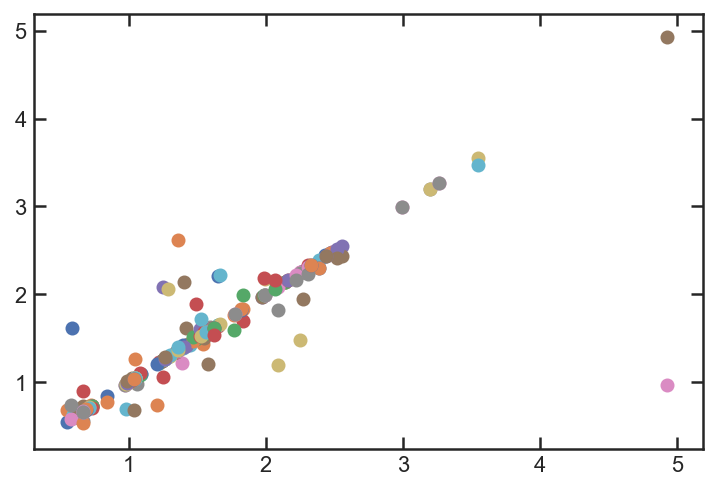

In [90]:
for z in GSD_all.zgrizli:
    if len(z) > 1:
        for i in range(len(z)):
            plt.scatter(z[0], z[i])

In [88]:
z

[1.575318883891514]

In [56]:
z_grizli = []
for i in GSD_all.id:
    spec_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*S*/*{}*.1D.fits'.format(i))
    rshift = []
    for fl in spec_list:
        subfield = fl.split('/')[-2]

        dat = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/{0}_lines_grizli.fits'.format(subfield)), format='fits').to_pandas()
        if dat.query('ID == {0}'.format(i)).z_50.values[0] > 0:
            rshift.append(dat.query('ID == {0}'.format(i)).z_50.values[0])
    z_grizli.append(rshift)
    
GSD_all['zgrizli'] = z_grizli

z_grizli = []
for i in GSD_all.id:
    spec_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*S*/*{}*.1D.fits'.format(i))
    rshift = []
    for fl in spec_list:
        subfield = fl.split('/')[-2]

        dat = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/{0}_lines_grizli.fits'.format(subfield)), format='fits').to_pandas()
        if dat.query('ID == {0}'.format(i)).z_50.values[0] > 0:
            rshift.append(dat.query('ID == {0}'.format(i)).z_50.values[0])
    z_grizli.append(rshift)
    
GSD_all['zgrizli'] = z_grizli

[[1.575318883891514], [2.577383610817953], [0.8411485043455519], [0.6706377306359553], [1.098978688791466], [1.307802826651694], [0.6675733418778722], [3.005899900501017], [1.515895659296277], [1.341709823209857], [2.659571977125149], [1.248211526879173], [1.491925888260978], [3.18093320607129], [2.876528923770224], [1.179569767729721], [2.644036975735168], [1.76633656004451], [0.6055487605167857], [0.6649088398783817], [1.188802334422374], [2.745242158652583], [0.6693762224125068], [1.993456784043516], [1.099300032967669], [1.568597876392754], [1.774975622932899], [1.428865296004957], [1.363600007664111], [1.222907471398417], [1.718531484702108], [0.9984359150519174], [0.6664305850786936], [2.633986911266744], [1.089594699366129], [1.313263244567824], [1.561920066027557], [1.318628157413741], [1.909374396764563], [1.094093691606942], [1.849407924205496], [1.097992599313309], [0.9520518527388171], [1.315124285880544], [1.416245980519933], [0.6194550584263085], [1.571278116817665], [1.2

In [46]:
rshift

1.022992843572704